# Regridding model data with xESMF

## Import python packages

In [8]:
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
import matplotlib.pyplot as plt

import xarray as xr
import numpy as np
import xesmf as xe

import warnings
warnings.filterwarnings('ignore')

## Open CMIP6 online catalog

In [2]:
col = google_cmip_col()
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


## Get data in xarray

### Create dictionary from the list of datasets 

In [3]:
cat = col.search(
    variable_id='tas', # surface air temperature
    experiment_id='historical', # only runs for the historical forcing period
    table_id='Amon', # monthly 
    grid_label='gn', # native model grid only
    member_id=['r1i1p1f1'], 
)
cat.df['source_id'].unique()

array(['GISS-E2-1-G', 'BCC-CSM2-MR', 'MIROC6', 'BCC-ESM1', 'MRI-ESM2-0',
       'CESM2-WACCM', 'CESM2', 'SAM0-UNICON', 'GISS-E2-1-H', 'CanESM5',
       'MPI-ESM-1-2-HAM', 'NESM3', 'CAMS-CSM1-0', 'MPI-ESM1-2-LR',
       'MPI-ESM1-2-HR', 'MCM-UA-1-0', 'GISS-E2-1-G-CC', 'NorESM2-LM',
       'FGOALS-g3', 'ACCESS-CM2', 'NorESM2-MM', 'FIO-ESM-2-0',
       'ACCESS-ESM1-5', 'CESM2-FV2', 'GISS-E2-2-H', 'CESM2-WACCM-FV2',
       'IITM-ESM', 'AWI-ESM-1-1-LR', 'CMCC-CM2-SR5', 'TaiESM1',
       'AWI-CM-1-1-MR', 'NorCPM1', 'CMCC-CM2-HR4', 'CAS-ESM2-0',
       'CMCC-ESM2', 'ICON-ESM-LR'], dtype=object)

In [4]:
cat = col.search(
    variable_id='tas', # surface air temperature
    experiment_id='historical', # only runs for the historical forcing period
    table_id='Amon', # monthly 
    grid_label='gn', # native model grid only
    source_id=['CESM2', 'CanESM5', 'MIROC6'], # this example works with 3 models but can easily expand to more models 
    member_id=['r1i1p1f1'], 
)

ddict = cat.to_dataset_dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs={'use_cftime':True}, 
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
list(ddict.keys())

['CMIP.CCCma.CanESM5.historical.Amon.gn',
 'CMIP.NCAR.CESM2.historical.Amon.gn',
 'CMIP.MIROC.MIROC6.historical.Amon.gn']

In [6]:
(ddict['CMIP.NCAR.CESM2.historical.Amon.gn'].tas.squeeze().shape, 
 ddict['CMIP.CCCma.CanESM5.historical.Amon.gn'].tas.squeeze().shape,
 ddict['CMIP.MIROC.MIROC6.historical.Amon.gn'].tas.squeeze().shape)

((1980, 192, 288), (1980, 64, 128), (1980, 128, 256))

## Regrid CMIP6 data to common grid

In [9]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1.0)),
    }
)

In [10]:
# create dictionary for reggridded data
ddict_regrid = dict()
for key in ddict.keys():
    print(key)
    ds_in = ddict[key].tas.squeeze()
    regridder = xe.Regridder(ds_in, ds_out, 'bilinear') # build regridder 
    ds_in_regrid = regridder(ds_in, keep_attrs=True) # apply regridder to data

    datetimeindex = ds_in_regrid.indexes['time'].to_datetimeindex() # convert to a pandas.DatetimeIndex
    ds_in_regrid['time'] = datetimeindex
    
    model = key.split('.')[2]
    print(model)
    ddict_regrid[model] = ds_in_regrid

CMIP.CCCma.CanESM5.historical.Amon.gn
CanESM5
CMIP.NCAR.CESM2.historical.Amon.gn
CESM2
CMIP.MIROC.MIROC6.historical.Amon.gn
MIROC6


In [36]:
ddict_regrid

{'CESM2': <xarray.DataArray 'tas' (time: 1980, lat: 180, lon: 360)> Size: 513MB
 dask.array<astype, shape=(1980, 180, 360), dtype=float32, chunksize=(600, 180, 360), chunktype=numpy.ndarray>
 Coordinates:
     member_id       <U8 32B 'r1i1p1f1'
     dcpp_init_year  float64 8B nan
   * lat             (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
   * lon             (lon) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
   * time            (time) datetime64[ns] 16kB 1850-01-15T12:00:00 ... 2014-1...
 Attributes: (12/20)
     cell_measures:  area: areacella
     cell_methods:   area: time: mean
     comment:        near-surface (usually, 2 meter) air temperature
     description:    near-surface (usually, 2 meter) air temperature
     frequency:      mon
     id:             tas
     ...             ...
     time_title:     Temporal mean
     title:          Near-Surface Air Temperature
     type:           real
     variable_id:    tas
     units:          K
     regri

## Concatenate all models

In [11]:
ds = np.empty((1980,180,360,3))
ds[:,:,:,0] = ddict_regrid['CESM2'].values
ds[:,:,:,1] = ddict_regrid['CanESM5'].values
ds[:,:,:,2] = ddict_regrid['MIROC6'].values

In [12]:
model = list(ddict_regrid.keys())
model

['CanESM5', 'CESM2', 'MIROC6']

In [13]:
ds_out_regrid = xr.DataArray(ds, dims=['time','lat','lon','model'],
                             coords={'time': ddict_regrid['CESM2'].time,
                                     'lat': ddict_regrid['CESM2'].lat,
                                     'lon': ddict_regrid['CESM2'].lon,
                                     'model': model})
ds_out_regrid                     

<xarray.DataArray (time: 1980, lat: 180, lon: 360, model: 3)> Size: 3GB
array([[[[245.32208252,   0.        ,   0.        ],
         [245.32208252,   0.        ,   0.        ],
         [245.32208252,   0.        ,   0.        ],
         ...,
         [245.32208252,   0.        ,   0.        ],
         [245.32208252,   0.        ,   0.        ],
         [245.32208252,   0.        ,   0.        ]],

        [[246.14381409,   0.        ,   0.        ],
         [246.1089325 ,   0.        ,   0.        ],
         [246.00801086,   0.        ,   0.        ],
         ...,
         [246.20559692,   0.        ,   0.        ],
         [246.1865387 ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ]],

        [[246.79824829,   0.        , 257.63549805],
         [246.73382568,   0.        , 257.5869751 ],
         [246.68966675,   0.        , 257.54037476],
         ...,
...
         ...,
         [244.93052673, 248.78874207, 249.14926147],
         [244.97463989,   0.        , 249.22529602],
         [  0.        ,   0.        ,   0.        ]],

        [[244.98979187,   0.        , 249.6578064 ],
         [245.00563049,   0.        , 249.71047974],
         [245.0213623 ,   0.        , 249.76222229],
         ...,
         [244.948349  ,   0.        , 249.51042175],
         [244.96260071,   0.        , 249.55784607],
         [  0.        ,   0.        ,   0.        ]],

        [[244.82896423,   0.        ,   0.        ],
         [244.84085083,   0.        ,   0.        ],
         [244.85336304,   0.        ,   0.        ],
         ...,
         [244.79345703,   0.        ,   0.        ],
         [244.80517578,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ]]]])
Coordinates:
  * time     (time) datetime64[ns] 16kB 1850-01-15T12:00:00 ... 2014-12-15T12...
  * lat      (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * model    (model) <U7 84B 'CanESM5' 'CESM2' 'MIROC6'

## Compute climatology of all regridded models

In [14]:
ds_out_regrid_clim = ds_out_regrid.mean('time')
ds_out_regrid_clim = ds_out_regrid_clim-273.15
ds_out_regrid_clim.shape

(180, 360, 3)

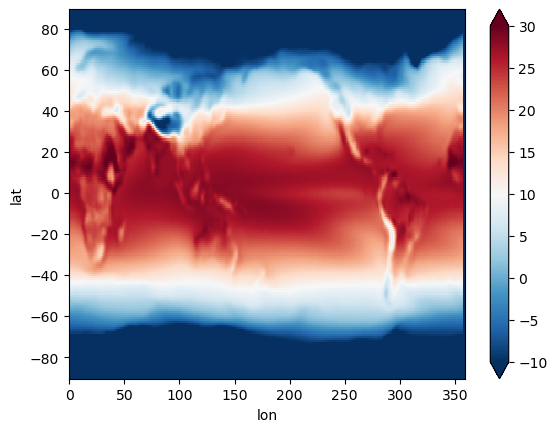

In [15]:
ds_out_regrid_clim.mean('model').plot(vmin=-10, vmax=30, cmap=plt.cm.RdBu_r)

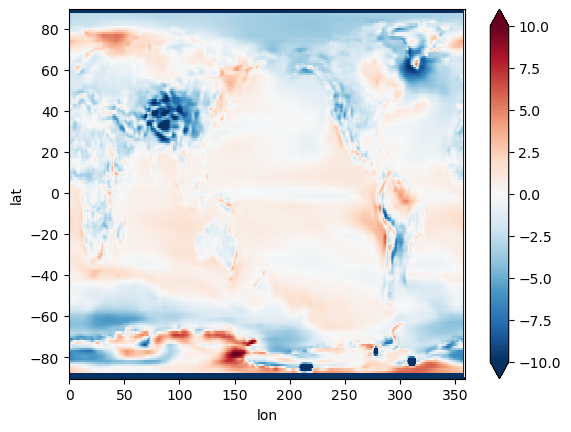

In [44]:
(ds_out_regrid_clim[:,:,1]-ds_out_regrid_clim[:,:,0]).plot(vmin=-10, vmax=10, cmap=plt.cm.RdBu_r)